In [11]:
import os
import json
import glob
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd

ROOT_DIR = './ids'

### analysis 1: feature importance with shap

In [12]:
def getExperiments(root_dir):
    experiments_list = []
    
    if not os.path.isdir(root_dir):
        print(f"Diretório raiz '{root_dir}' não encontrado.")
        return experiments_list

    ids = os.listdir(root_dir)

    for id_folder in ids:
        results_path = os.path.join(root_dir, id_folder, 'results')
        
        if os.path.isdir(results_path):
            datasets = os.listdir(results_path)

            for dataset in datasets:
                dataset_path = os.path.join(results_path, dataset)

                if os.path.isdir(dataset_path):
                    experiments = os.listdir(dataset_path)

                    for experiment in experiments:
                        experiment_path = os.path.join(dataset_path, experiment)
                        
                        if os.path.isdir(experiment_path):
                            experiments_list.append({
                                'ids': id_folder,
                                'dataset': dataset,
                                'type': experiment,
                                'path': experiment_path
                            })
    return experiments_list

In [13]:
experiments = getExperiments(ROOT_DIR)


--- Project: ocpp-ids | Dataset: ocppflowmeter | Exp: baseline ---
  -> Generating outputs for Exp: baseline
    -> Feature ranking saved to ./ids/ocpp-ids/results/ocppflowmeter/baseline/shap/shap_ranking.json


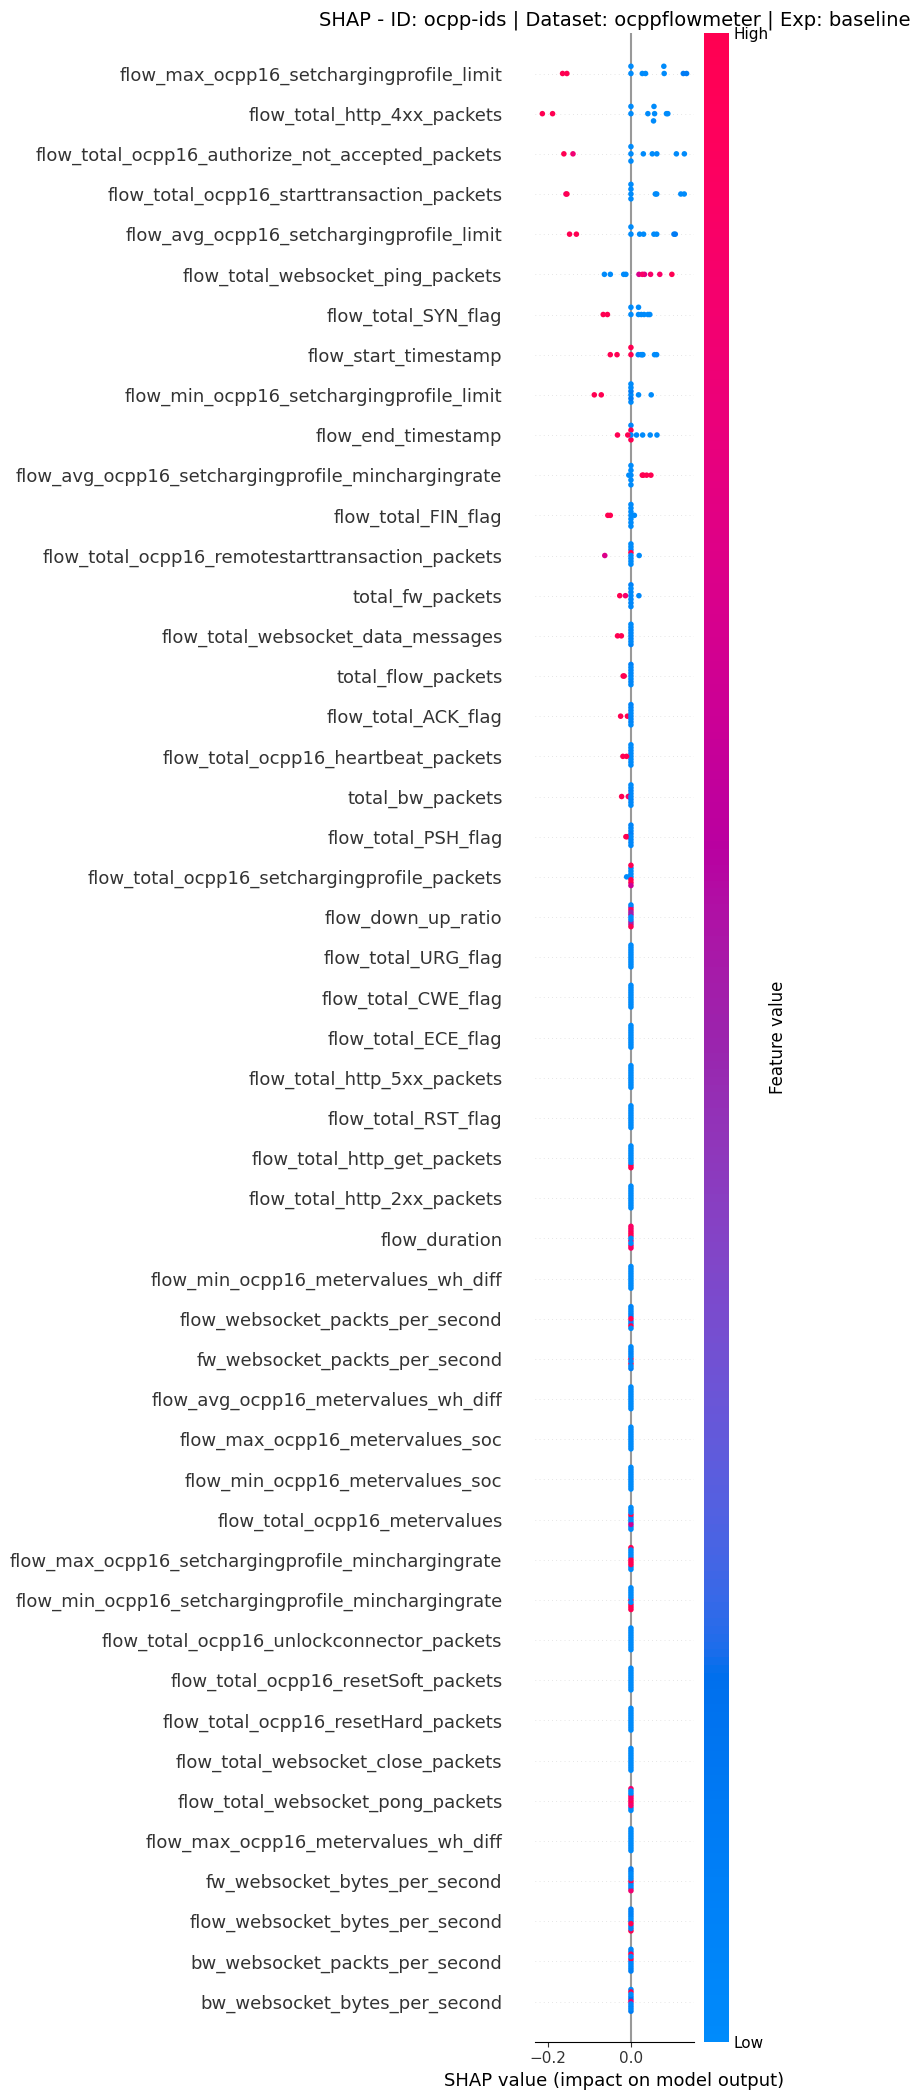


--- Project: ocpp-ids | Dataset: cicflowmeter | Exp: baseline ---
  -> Generating outputs for Exp: baseline
    -> Feature ranking saved to ./ids/ocpp-ids/results/cicflowmeter/baseline/shap/shap_ranking.json


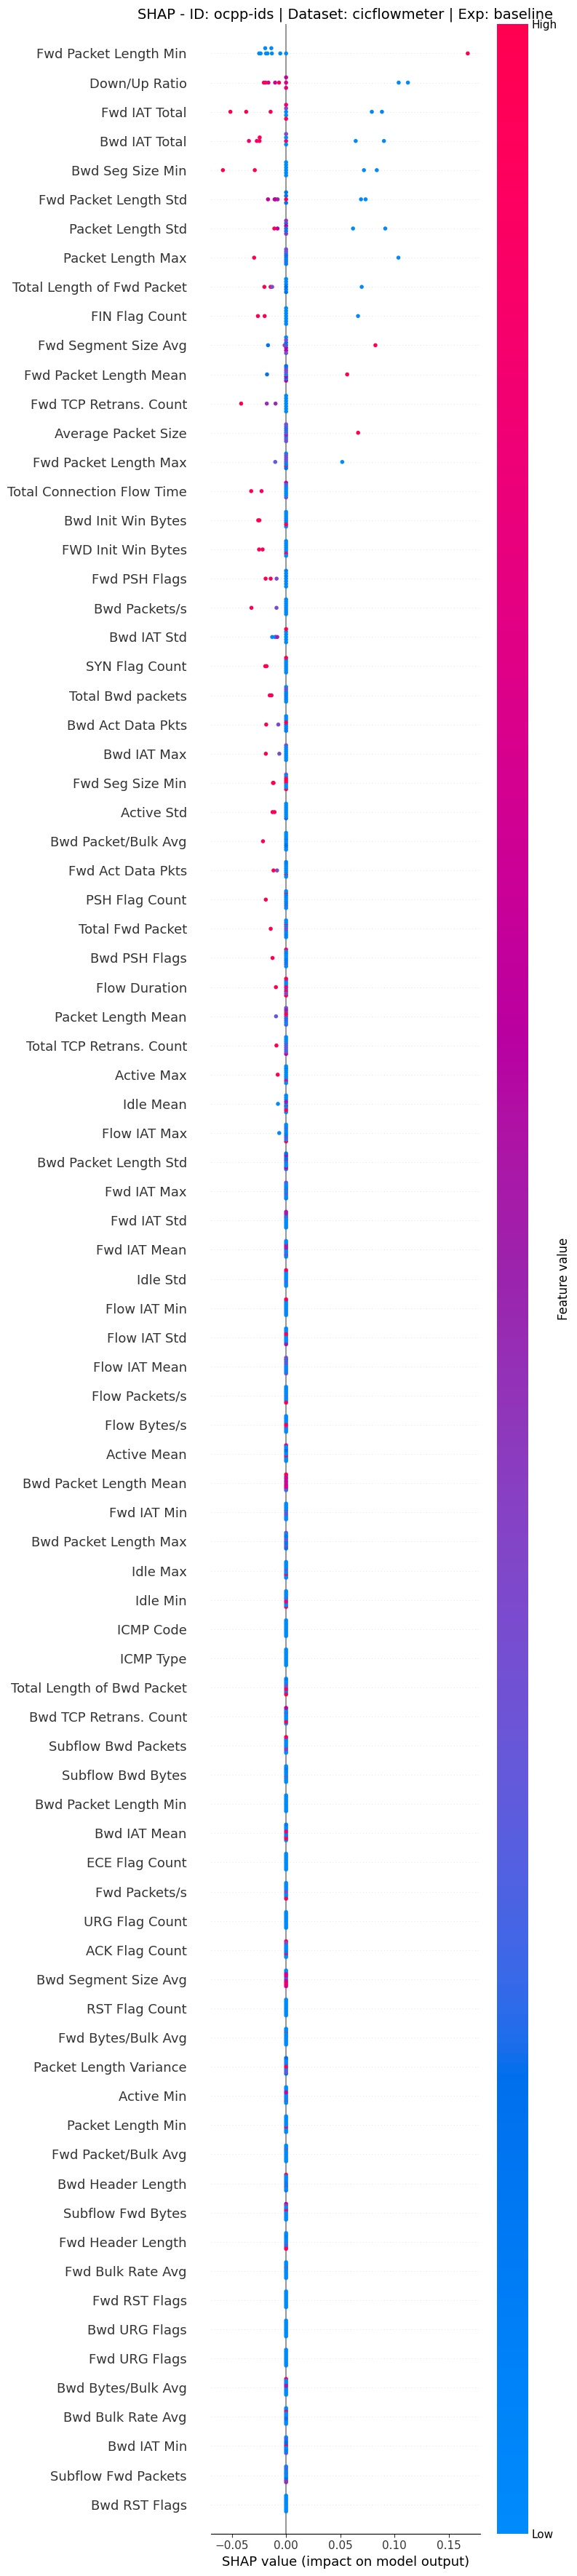

In [14]:
for exp in experiments:
    if exp['type'] != 'baseline':
        continue
    
    print(f"\n--- Project: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']} ---")
    shap_file = os.path.join(exp['path'], 'shap', 'shap_values.npy')

    if not os.path.exists(shap_file):
        print("  -> No SHAP file found for this experiment.")
        continue
    
    try:
        shap_dir = os.path.dirname(shap_file)
        data_file = os.path.join(shap_dir, 'shap_data.npy')
        features_file = os.path.join(shap_dir, 'shap_features.json')
        class_names_file = os.path.join(shap_dir, 'shap_class_names.json')

        shap_values = np.load(shap_file, allow_pickle=True)
        data_samples = np.load(data_file, allow_pickle=True)
        
        with open(features_file, 'r') as f:
            feature_data = json.load(f)
            if isinstance(feature_data, dict):
                feature_names = feature_data.get('feature_names', [])
            else:
                feature_names = feature_data

        class_names = None
        if os.path.exists(class_names_file):
            with open(class_names_file, 'r') as f:
                class_data = json.load(f)
                if isinstance(class_data, dict):
                    class_names = class_data.get('class_names')
                else:
                    class_names = class_data
        
        print(f"  -> Generating outputs for Exp: {exp['type']}")
        
        if shap_values.ndim == 3 and shap_values.shape[2] == 1:
            shap_values_to_plot = shap_values[:, :, 0]
        else:
            shap_values_to_plot = shap_values
        
        mean_abs_shap = np.abs(shap_values_to_plot).mean(axis=0)
        sorted_idx = np.argsort(mean_abs_shap)
        sorted_features_shap_asc = [feature_names[i] for i in sorted_idx]
        
        plots_path = os.path.join(os.getcwd(), 'notebooks', 'plots', exp['ids'])
        os.makedirs(plots_path, exist_ok=True)
        
        out_file = os.path.join(exp['path'], 'shap', 'shap_ranking.json')
        with open(out_file, 'w') as f:
            json.dump(sorted_features_shap_asc, f, indent=2)
        print(f"    -> Feature ranking saved to {out_file}")

        plt.figure()
        shap.summary_plot(
            shap_values_to_plot, 
            data_samples, 
            feature_names=feature_names, 
            class_names=class_names,
            show=False, 
            max_display=len(feature_names)
        )
        
        plt.title(f"SHAP - ID: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']}", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_path, f"shap_{exp['type']}_{exp['dataset']}.png"))
        plt.show()

    except Exception as e:
        print(f"    WARNING: Failed to process {shap_file}. Error: {e}")

### LIME vs SHAP

In [15]:
def transformLIME(input_file_path):
    if not os.path.exists(input_file_path):
        print(f"Error: Input file '{input_file_path}' not found.")
        return False
        
    try:
        with open(input_file_path, 'r') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: File '{input_file_path}' is not a valid JSON.")
        return False
    except Exception as e:
        print(f"Error reading file: {e}")
        return False

    if not isinstance(data, dict):
        print("Error: The JSON content is not a dictionary.")
        return False

    keys_list = list(data.keys())

    input_dir = os.path.dirname(input_file_path)
    output_file_path = os.path.join(input_dir, 'lime_ranking.json')

    try:
        with open(output_file_path, 'w') as f:
            json.dump(keys_list, f, indent=2)
        print(f"Success: Keys list saved to '{output_file_path}'")
        return True
    except Exception as e:
        print(f"Error writing file: {e}")
        return False


--- Project: ocpp-ids | Dataset: ocppflowmeter | Exp: baseline ---
Success: Keys list saved to './ids/ocpp-ids/results/ocppflowmeter/baseline/lime/lime_ranking.json'

Starting order comparison...
The JSON lists have different orders.

Element-by-element comparison:


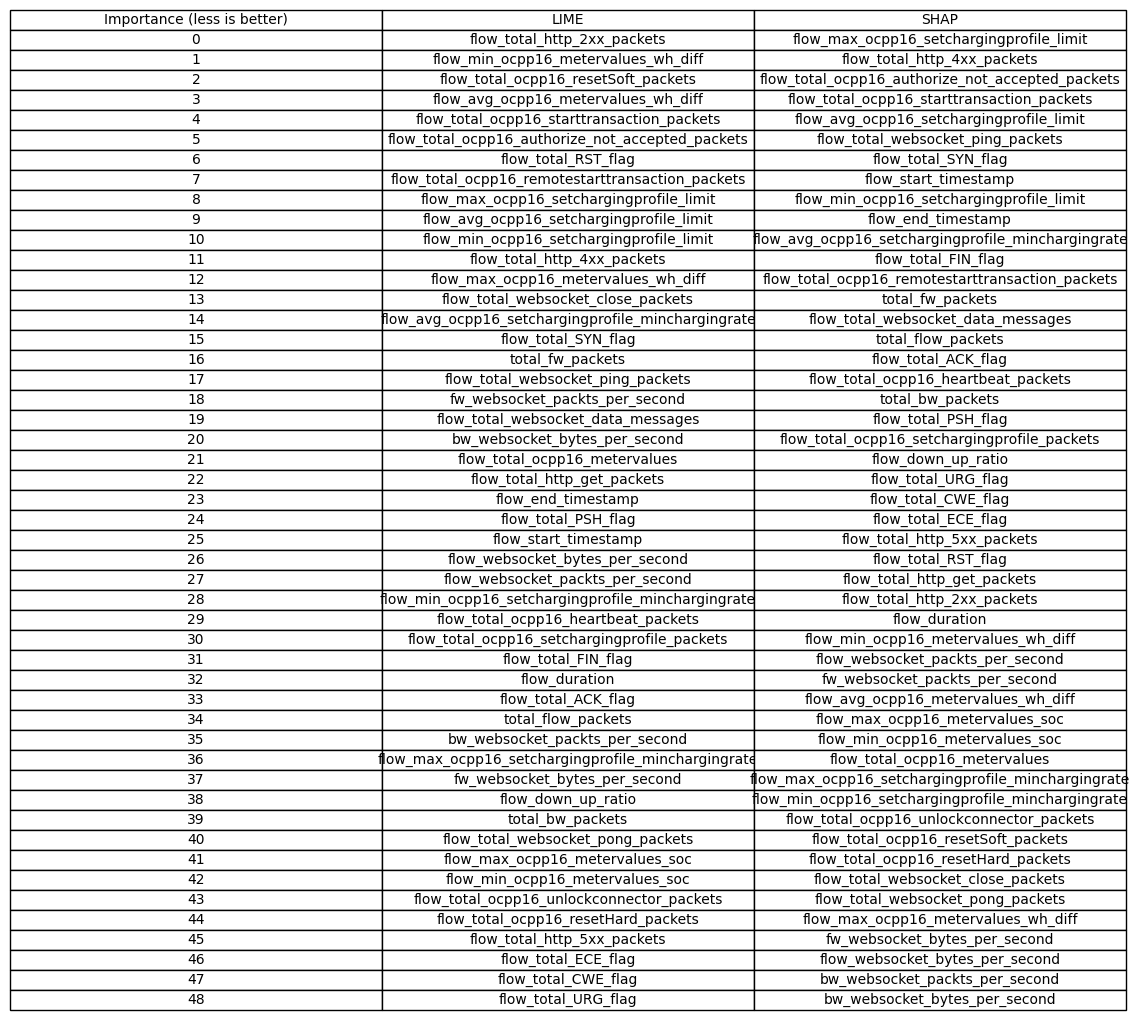


--- Project: ocpp-ids | Dataset: cicflowmeter | Exp: baseline ---
Success: Keys list saved to './ids/ocpp-ids/results/cicflowmeter/baseline/lime/lime_ranking.json'

Starting order comparison...
The JSON lists have different orders.

Element-by-element comparison:


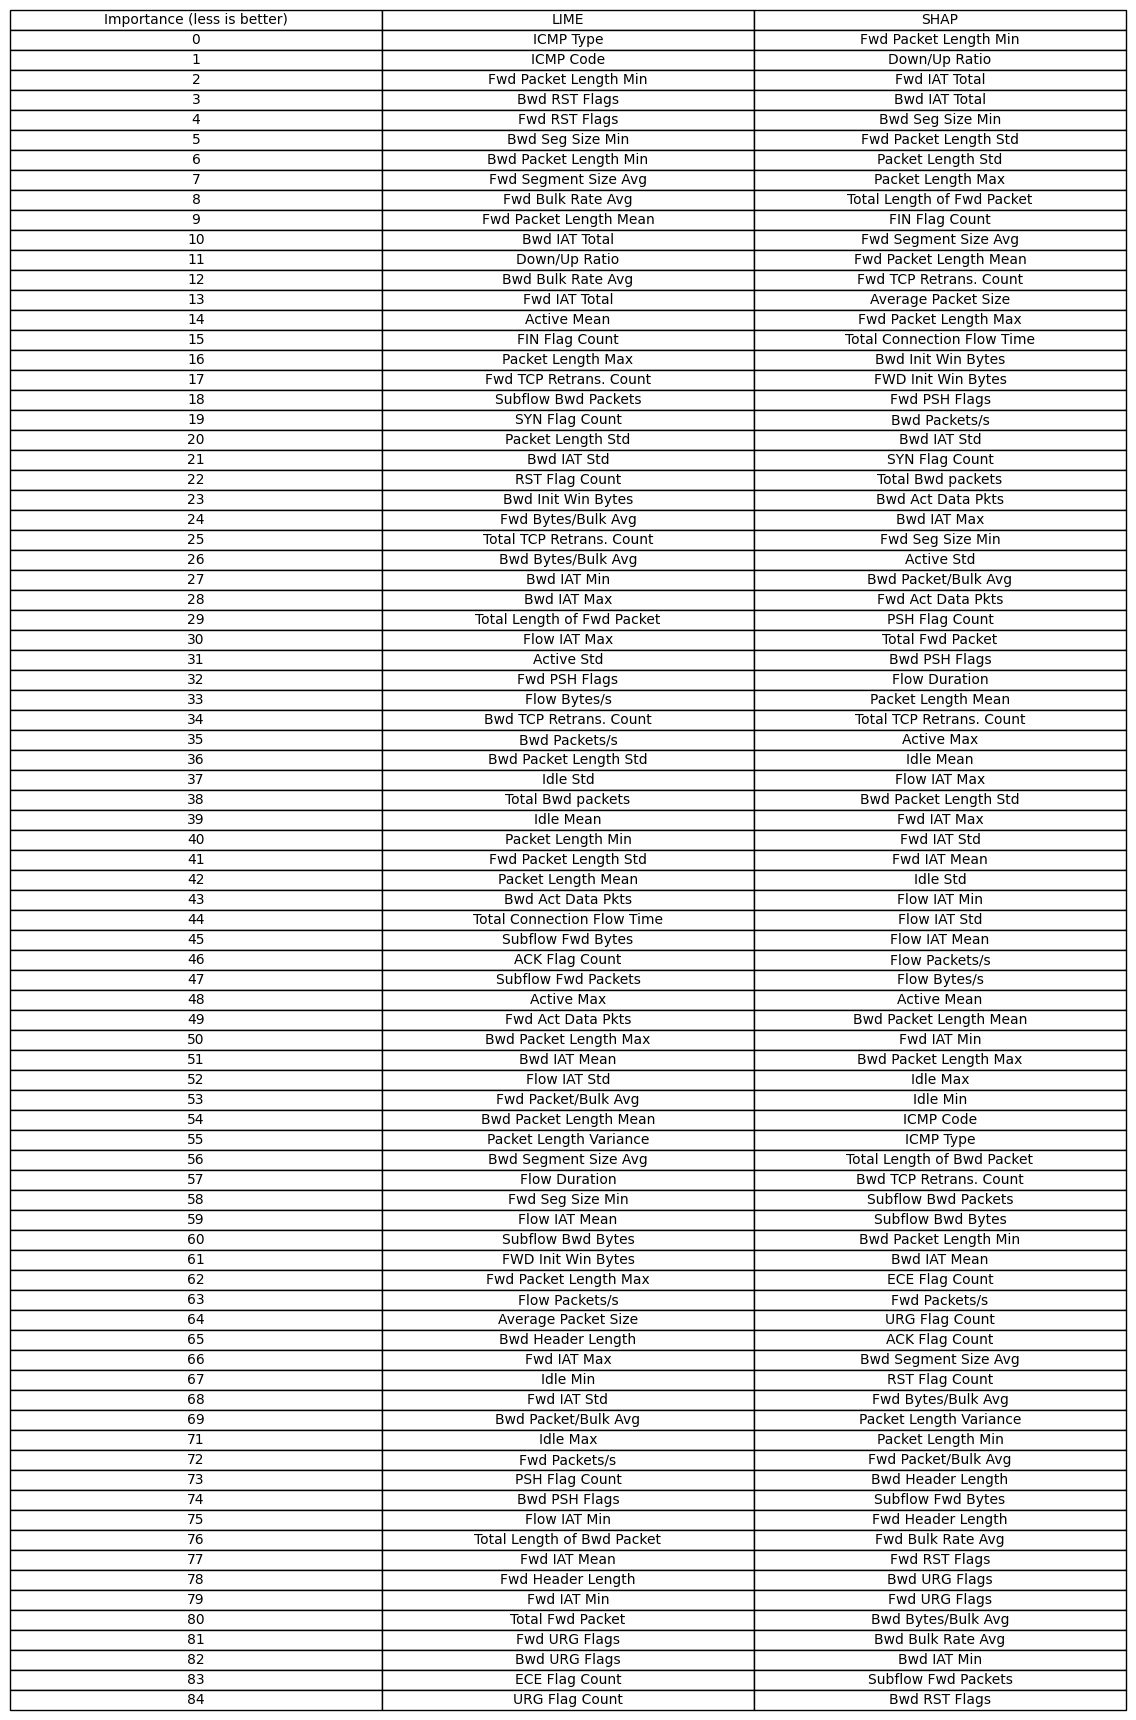

In [16]:
for exp in experiments:
    if exp['type'] != 'baseline':
        continue
    
    print(f"\n--- Project: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']} ---")
    transformLIME(os.path.join(exp['path'], 'lime', 'lime_feature_importance.json'))

    file_path_1 = os.path.join(exp['path'], 'lime', 'lime_ranking.json')
    file_path_2 = os.path.join(exp['path'], 'shap', 'shap_ranking.json')
    
    if not os.path.exists(file_path_1) or not os.path.exists(file_path_2):
        print("Error: One or both files were not found. Skipping comparison.")
    else:
        try:
            with open(file_path_1, 'r') as f1, open(file_path_2, 'r') as f2:
                data1 = json.load(f1)
                data2 = json.load(f2)
                
            if not isinstance(data1, list) or not isinstance(data2, list):
                print("Error: The content of one or both files is not a list. Skipping comparison.")
            elif len(data1) != len(data2):
                print("Warning: The lists have different sizes. The order cannot be compared.")
            elif sorted(data1) != sorted(data2):
                print("Warning: The content of the lists is different. Order comparison may be misleading.")
            else:
                print("\nStarting order comparison...")

                data1 = data1[::-1]
                data2 = data2[::-1]
                
                if data1 == data2:
                    print("The JSON lists have the same order. The order of elements is identical.")
                else:
                    print("The JSON lists have different orders.")
                    print("\nElement-by-element comparison:")
                    
                    comparison_data = []
                    for i, (item1, item2) in enumerate(zip(data1, data2)):
                        if item1 != item2:
                            comparison_data.append([i, item1, item2])
                    
                    comparison_df = pd.DataFrame(comparison_data, columns=['Importance (less is better)', 'LIME', 'SHAP'])
                    fig, ax = plt.subplots(figsize=(12, 6))  # aumenta o tamanho
                    ax.axis('off')
                    table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns, cellLoc='center', loc='center')
                    table.auto_set_font_size(False)
                    table.set_fontsize(10)
                    table.scale(1.2, 1.2)
                    plt.savefig("comparison_table.png", bbox_inches="tight")
                    plt.show()
                    
        except json.JSONDecodeError:
            print("Error: One of the files is not a valid JSON. Skipping comparison.")
        except Exception as e:
            print(f"Unexpected error: {e}. Skipping comparison.")    


--- Generating grouped plots for ID: ocpp-ids | Dataset: cicflowmeter ---


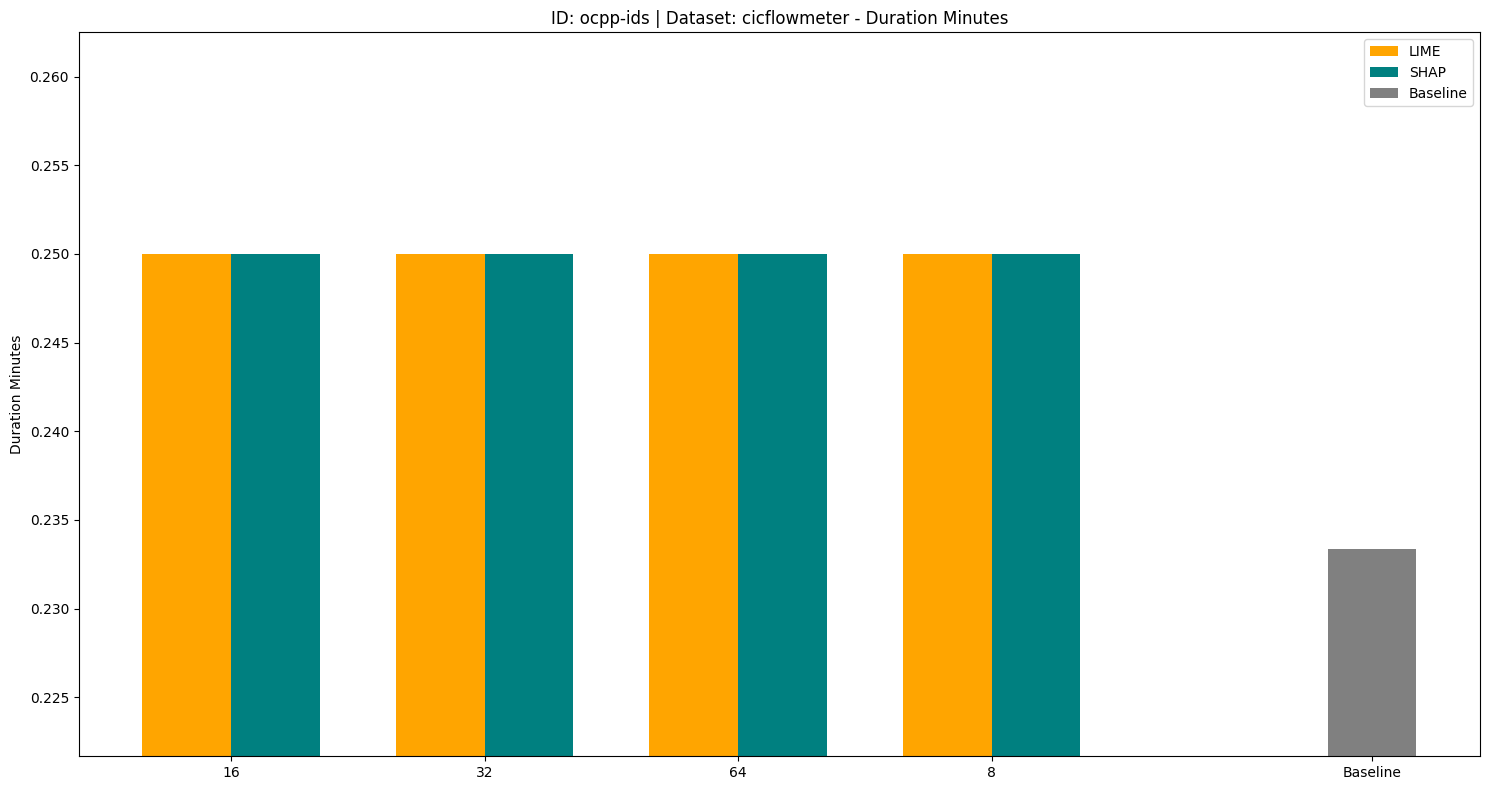

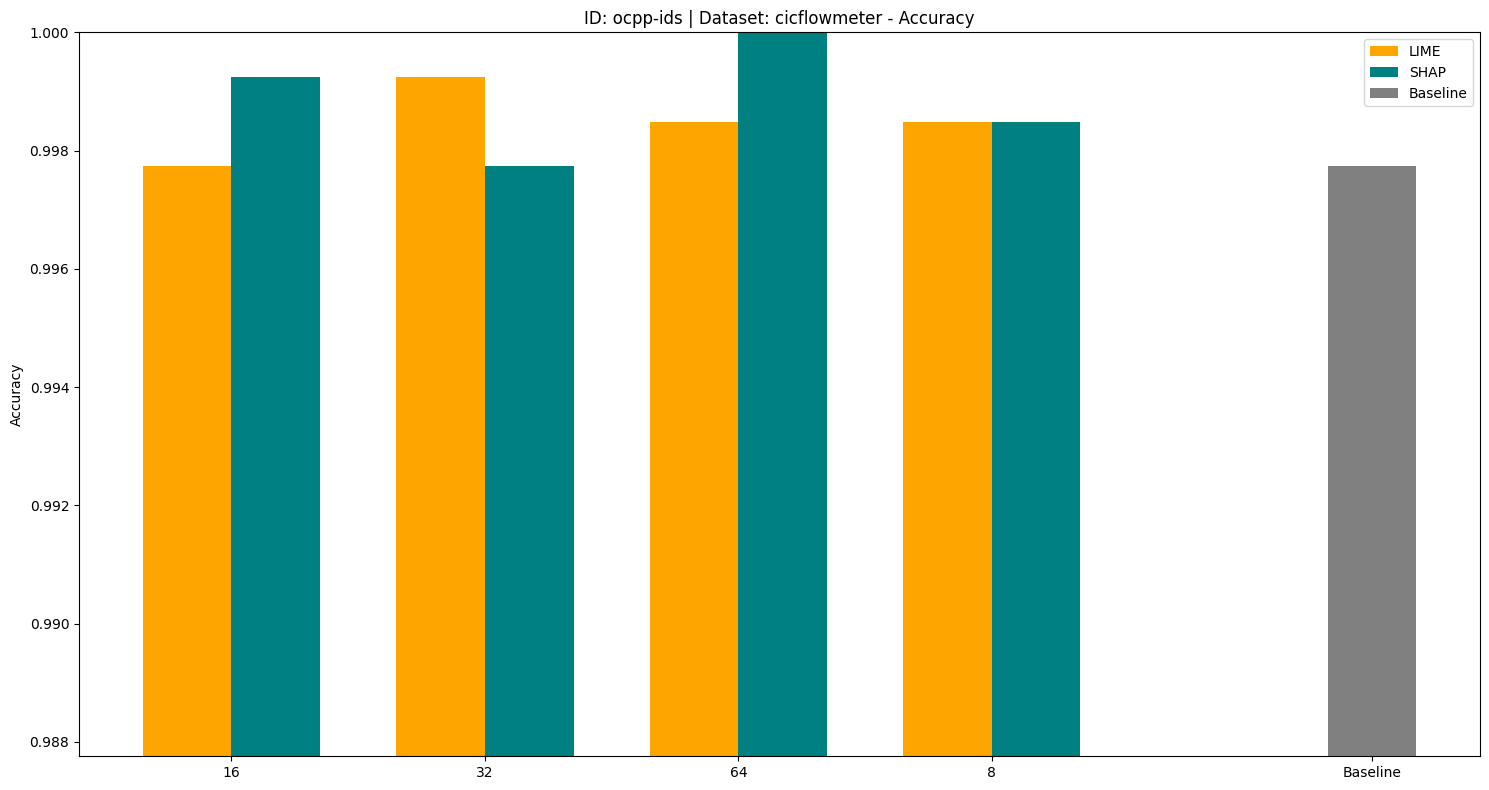

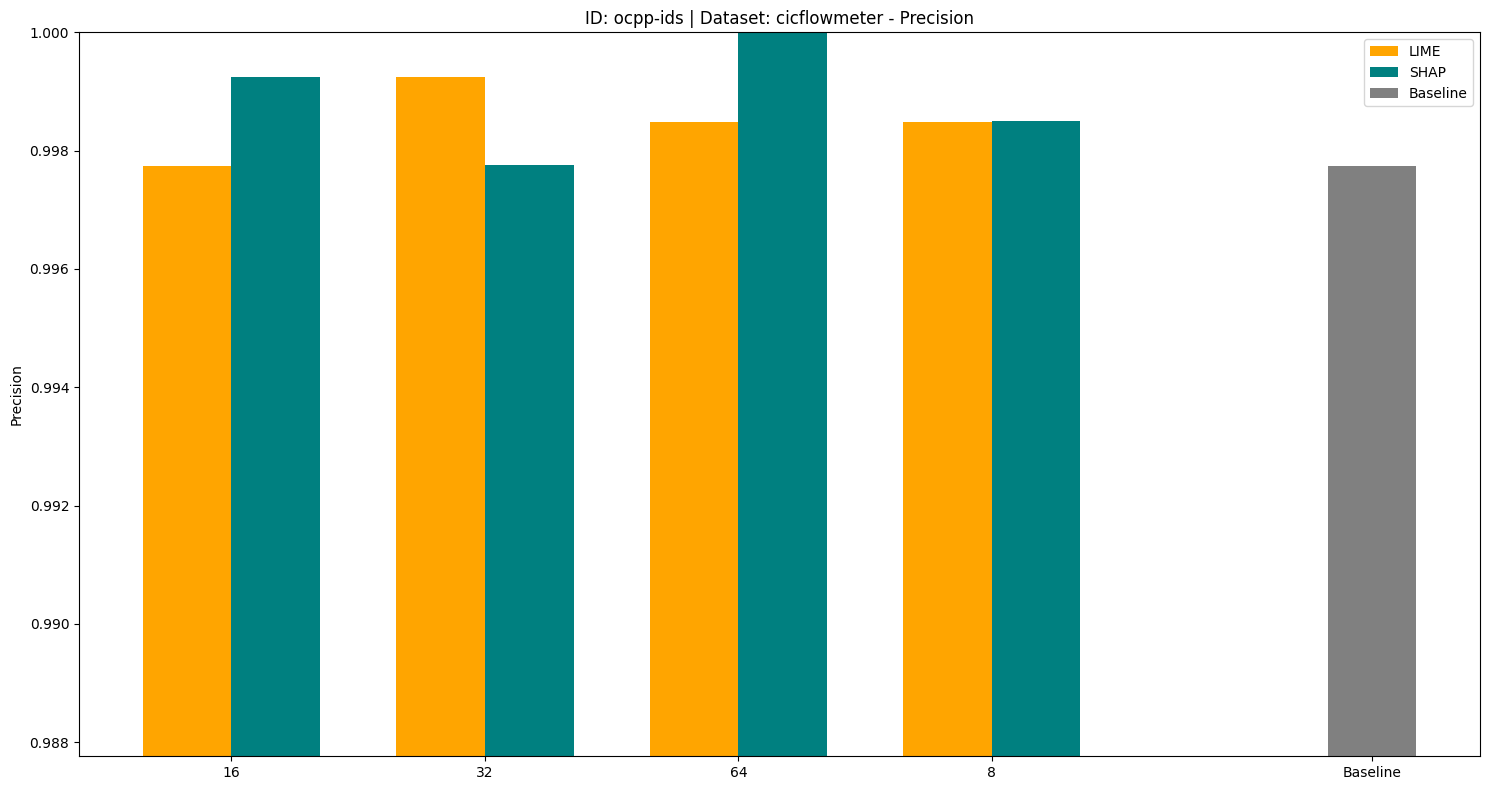

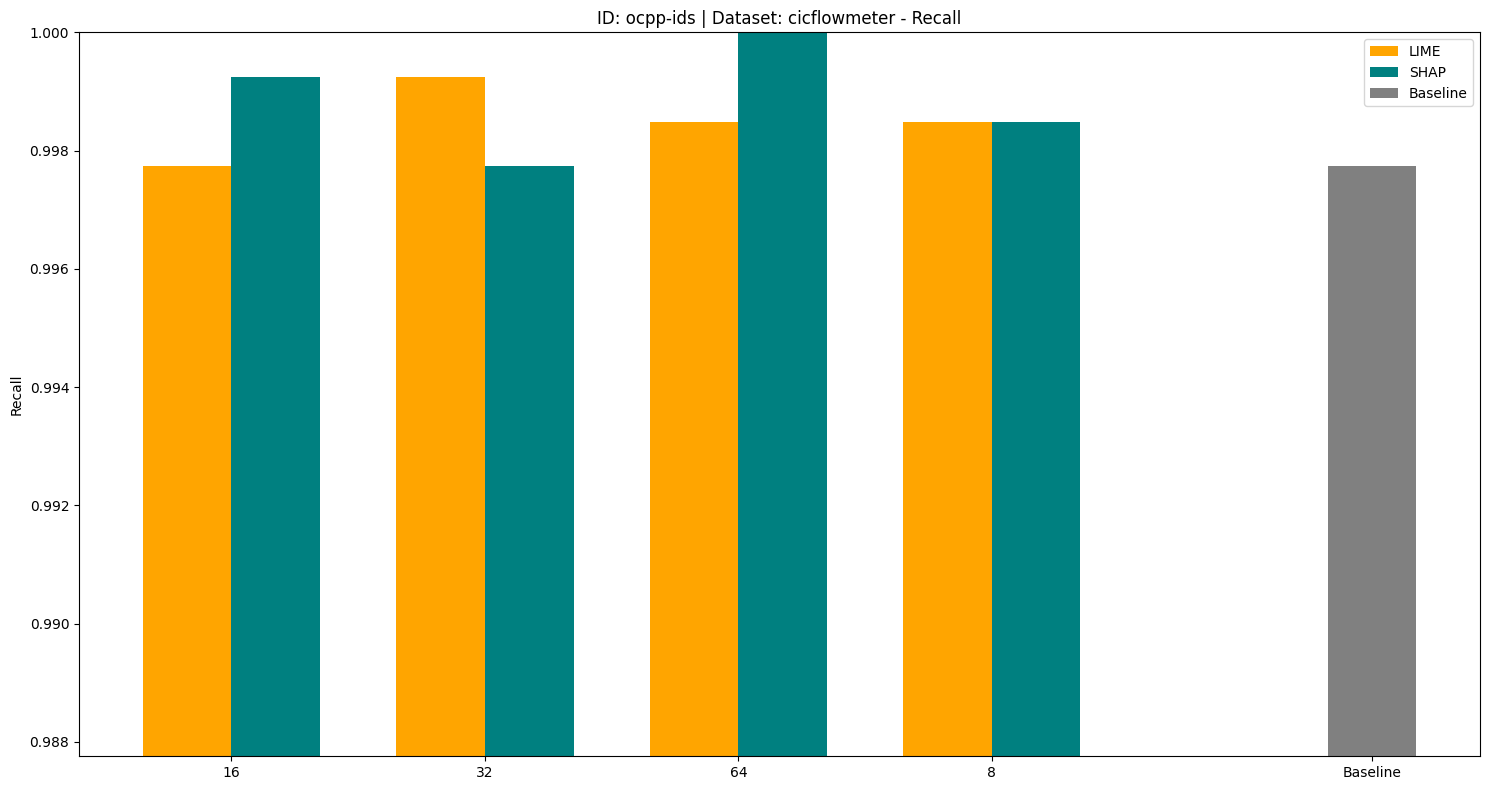

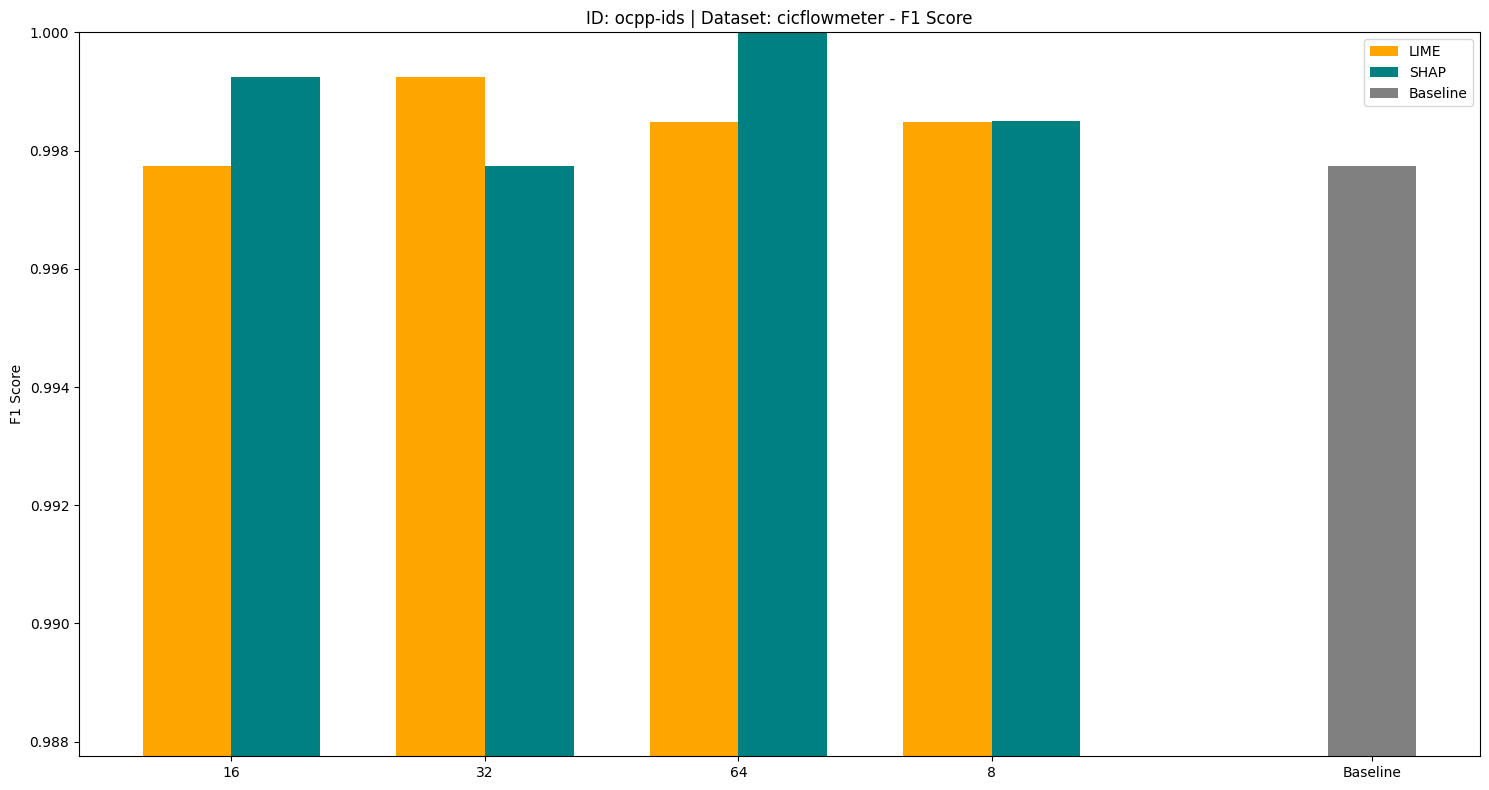


--- Generating grouped plots for ID: ocpp-ids | Dataset: ocppflowmeter ---


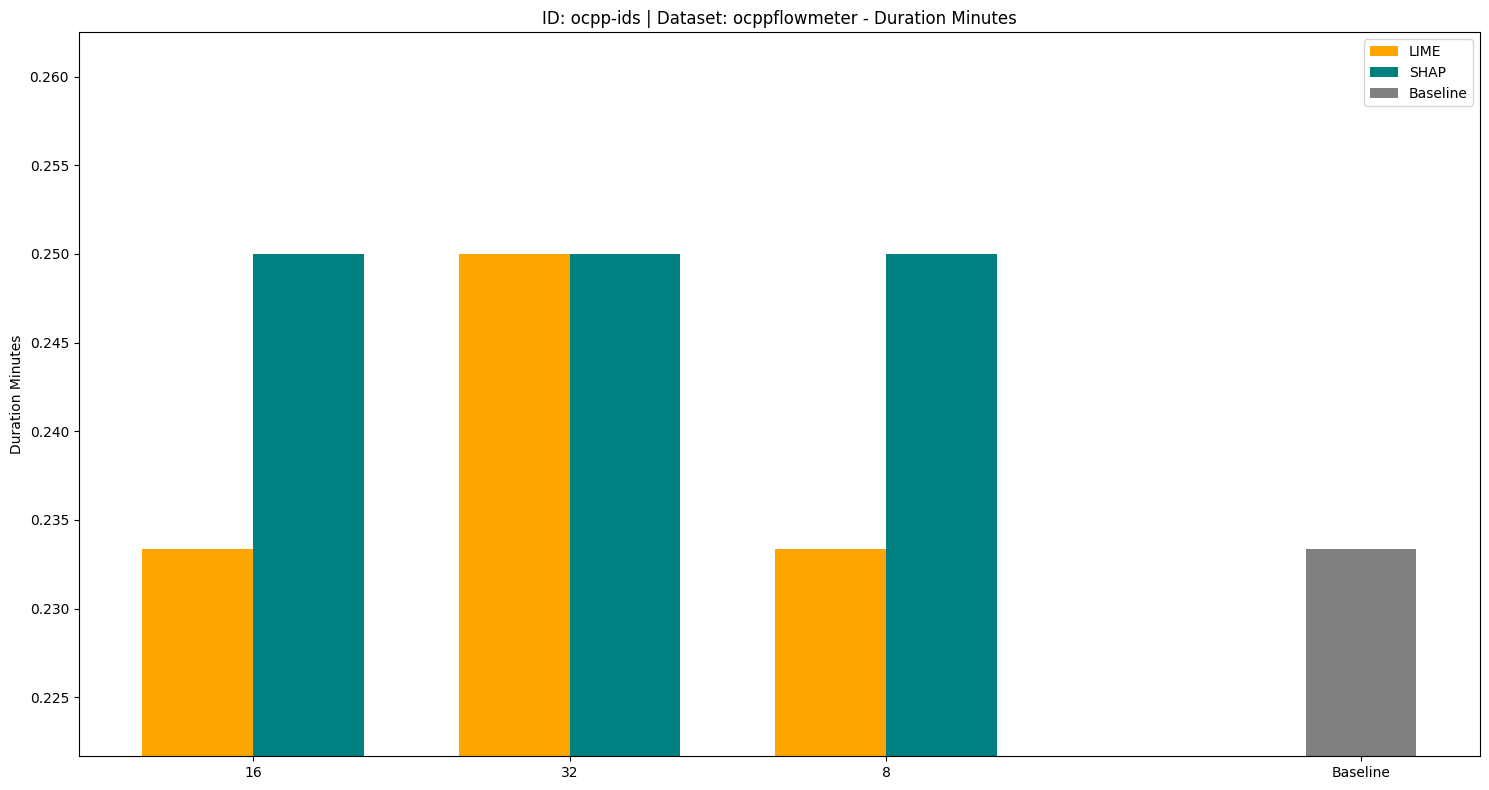

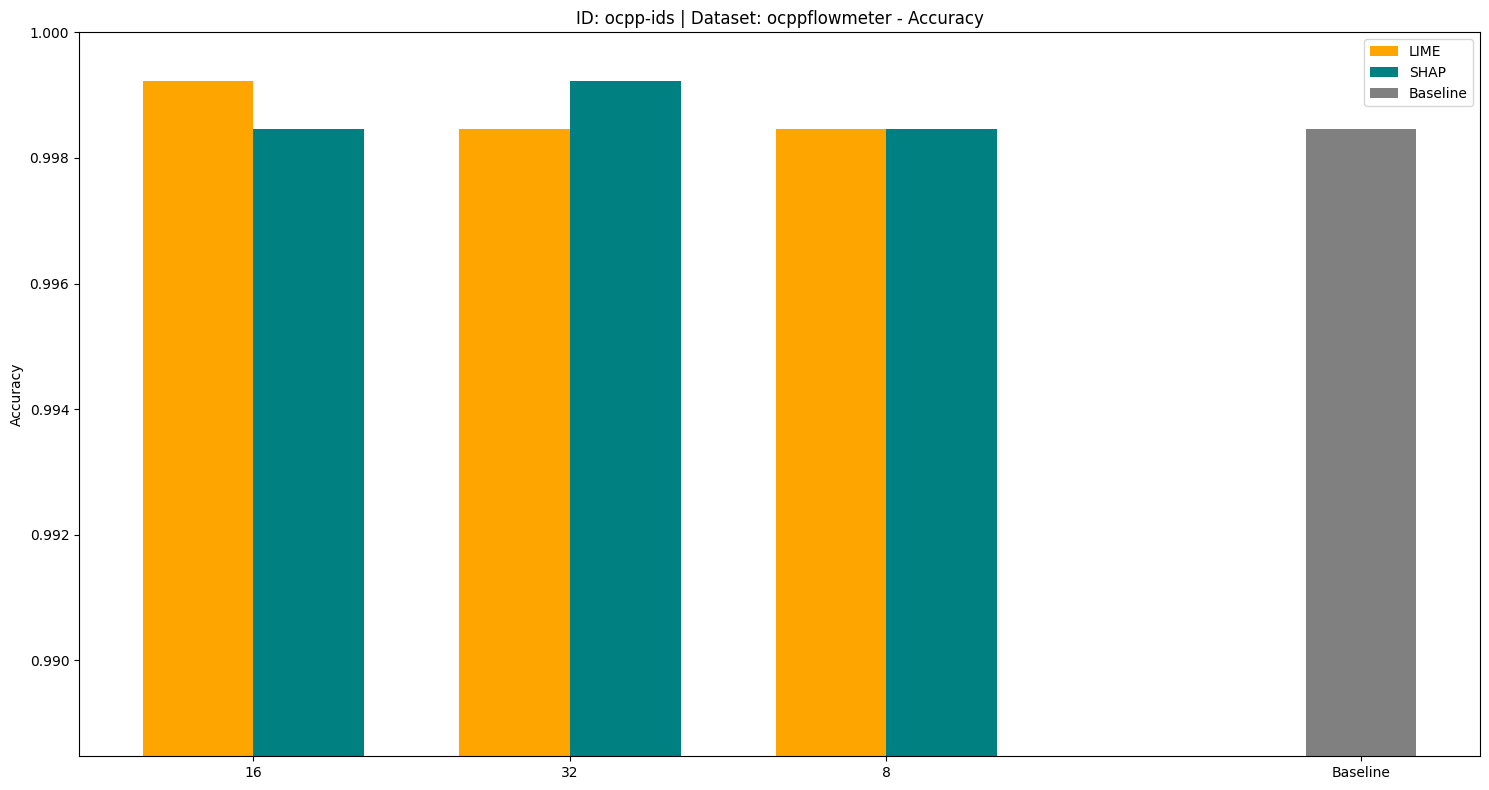

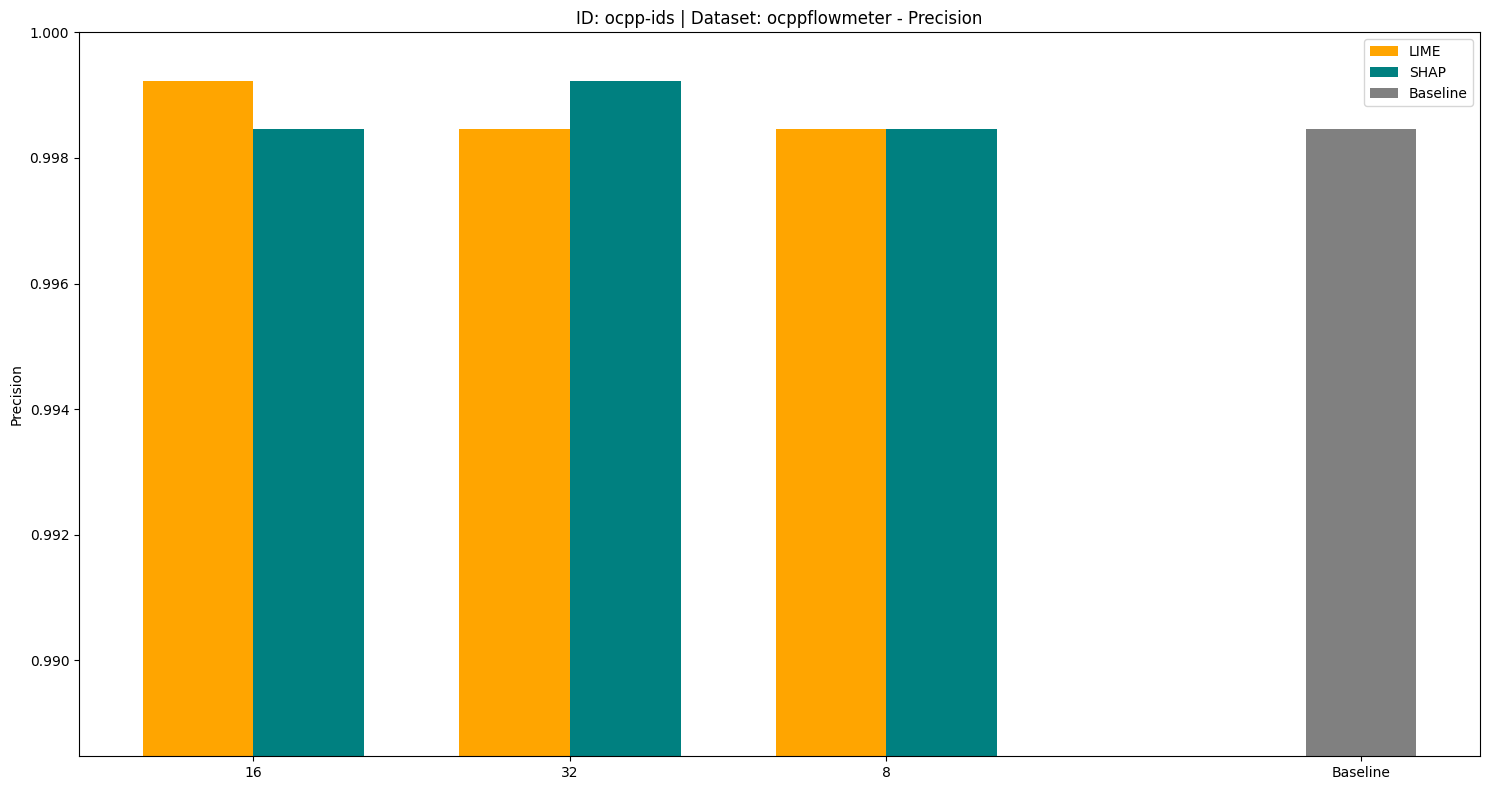

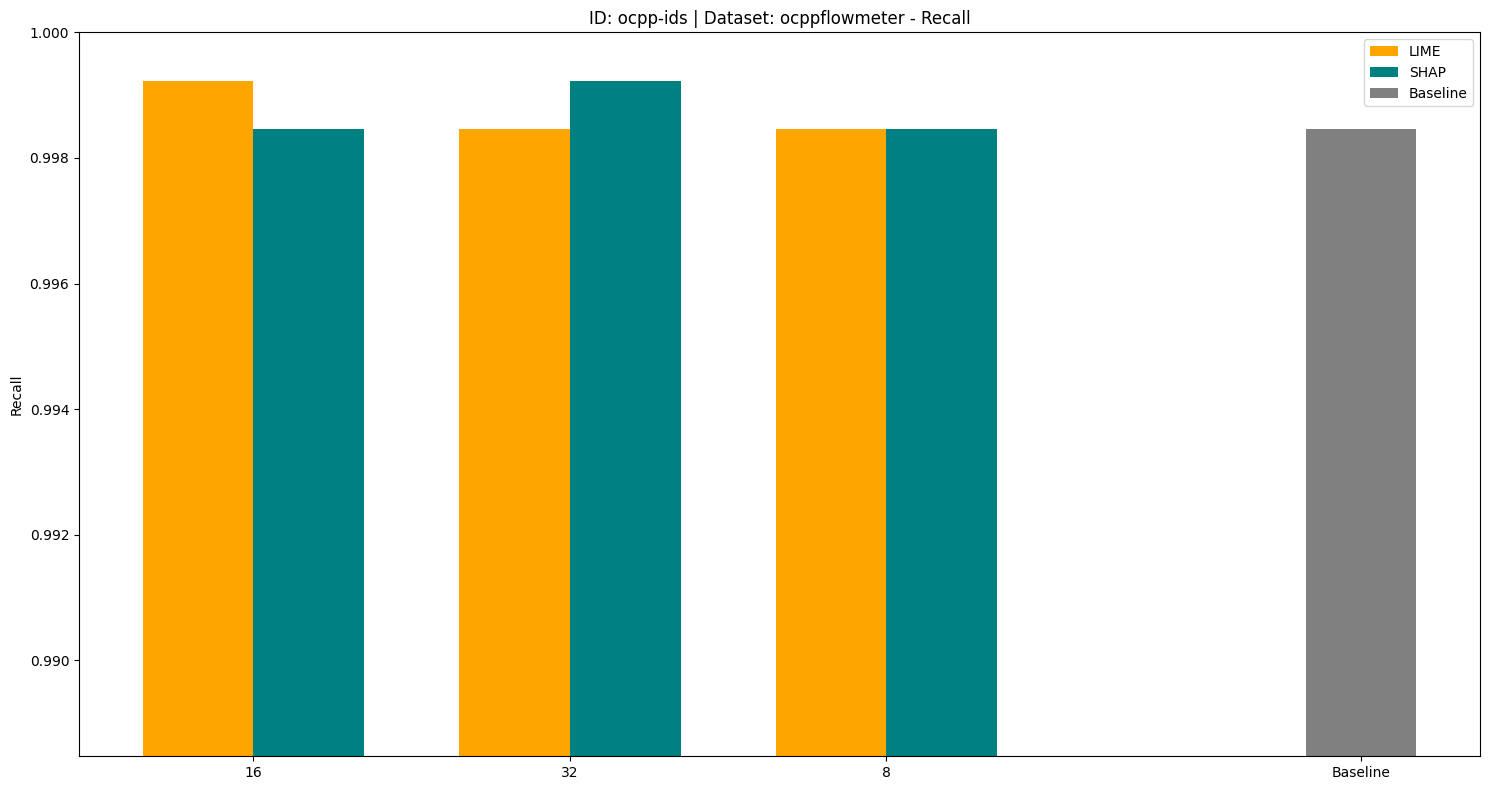

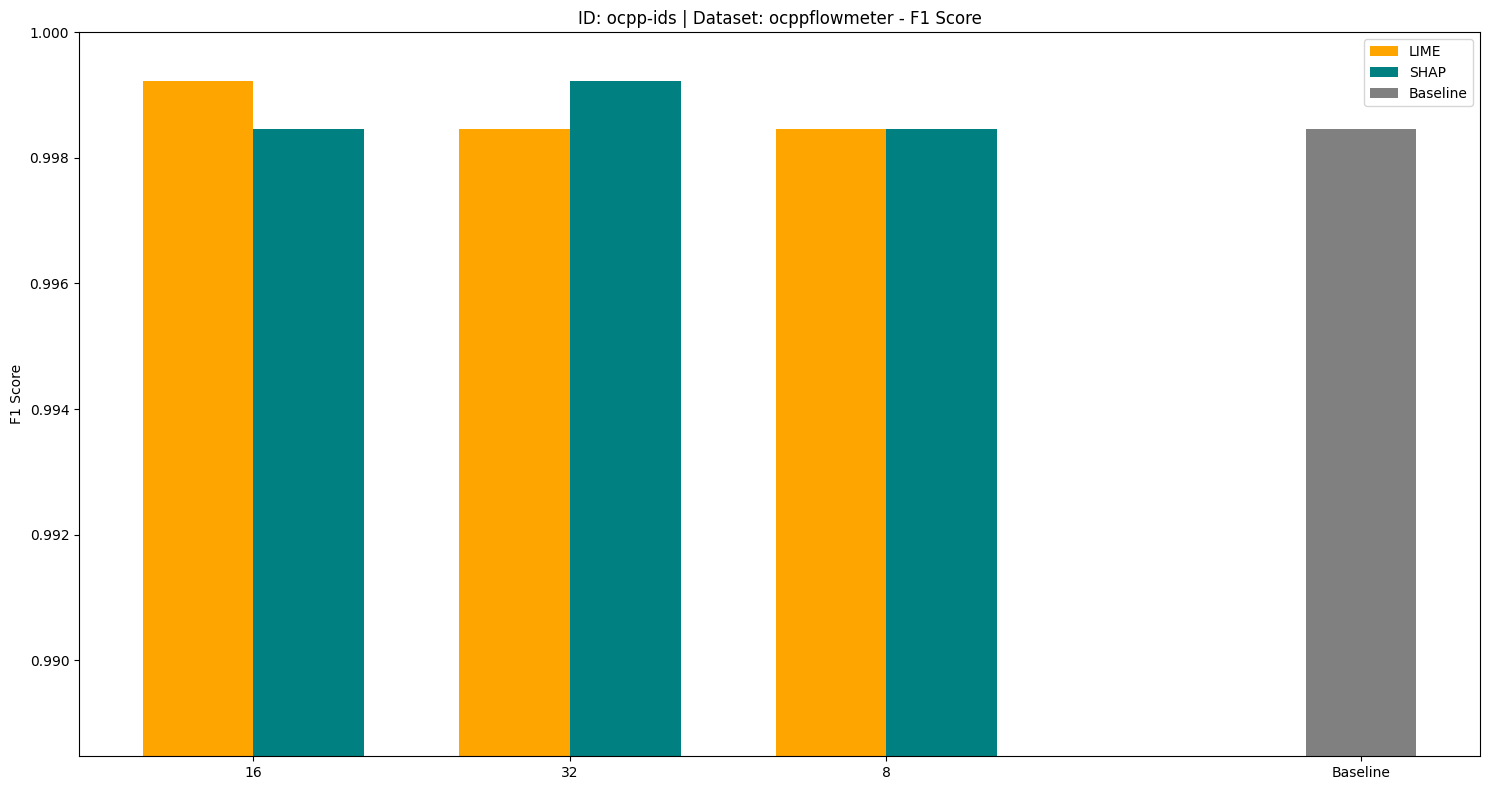

In [17]:
def get_latest_metrics(exp_list):
    all_metrics = []
    
    for exp in exp_list:
        metrics_path = os.path.join(exp['path'], f"{exp['type']}.csv")
        
        if os.path.exists(metrics_path):
            try:
                df = pd.read_csv(metrics_path)
                
                last_row = df.iloc[-1].to_dict()
                
                start_time_str = df.iloc[0]['timestamp']
                end_time_str = df.iloc[-1]['timestamp']
                
                start_time = pd.to_datetime(start_time_str)
                end_time = pd.to_datetime(end_time_str)
                
                duration_minutes = (end_time - start_time).total_seconds() / 60
                
                experiment_info = {
                    'ids': exp['ids'],
                    'dataset': exp['dataset'],
                    'experiment_type': exp['type'],
                    'duration_minutes': duration_minutes,
                    'accuracy': last_row['accuracy'],
                    'precision': last_row['weighted avg_precision'],
                    'recall': last_row['weighted avg_recall'],
                    'f1_score': last_row['weighted avg_f1_score']
                }
                all_metrics.append(experiment_info)
                
            except Exception as e:
                print(f"Error processing {metrics_path}: {e}")
                
    return pd.DataFrame(all_metrics)

def plot_all_experiments_grouped(df, metric, title_prefix, width=0.35):
    plt.figure(figsize=(15, 8))

    df_filtered = df[df['experiment_type'].str.contains('lime_|shap_|baseline')]
    
    lime_df = df_filtered[df_filtered['experiment_type'].str.contains('lime_')].sort_values('experiment_type')
    shap_df = df_filtered[df_filtered['experiment_type'].str.contains('shap_')].sort_values('experiment_type')
    baseline_df = df_filtered[df_filtered['experiment_type'] == 'baseline']
    
    grouped_labels = [exp.split('_')[-1] for exp in lime_df['experiment_type']]
    grouped_x = np.arange(len(grouped_labels))

    plt.bar(grouped_x - width/2, lime_df[metric], width, label='LIME', color='orange')
    plt.bar(grouped_x + width/2, shap_df[metric], width, label='SHAP', color='teal')
    
    baseline_x_pos = grouped_x[-1] + 1.5
    
    plt.bar(baseline_x_pos, baseline_df[metric], width, label='Baseline', color='gray')
    
    all_labels = grouped_labels + ['Baseline']
    all_x = np.append(grouped_x, baseline_x_pos)
    
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{title_prefix} - {metric.replace('_', ' ').title()}")
    plt.xticks(all_x, all_labels)
    plt.legend()
    
    # Set y-axis limits
    all_data = df_filtered[metric]
    min_val = all_data.min()
    max_val = all_data.max()
    
    if min_val > 0.95:
      plt.ylim(bottom=min_val * 0.99, top=1.0)
    else:
      plt.ylim(bottom=min_val * 0.95, top=max_val * 1.05)

    plt.tight_layout()
    plt.show()

metrics_df = get_latest_metrics(experiments)
grouped = metrics_df.groupby(['ids', 'dataset'])

for name, group in grouped:
    ids_name, dataset_name = name
    
    print(f"\n--- Generating grouped plots for ID: {ids_name} | Dataset: {dataset_name} ---")
    
    title = f"ID: {ids_name} | Dataset: {dataset_name}"
    
    plot_all_experiments_grouped(group, 'duration_minutes', title)
    plot_all_experiments_grouped(group, 'accuracy', title)
    plot_all_experiments_grouped(group, 'precision', title)
    plot_all_experiments_grouped(group, 'recall', title)
    plot_all_experiments_grouped(group, 'f1_score', title)